In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier



In [2]:
train = pd.read_csv('KDDTrain+.txt')
test = pd.read_csv('KDDTest+.txt')

In [3]:
column_names = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted'
,'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate'
,'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])
train.columns=column_names
test.columns=column_names

In [4]:
data = pd.concat([train, test], axis=0)


In [5]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [6]:
data = data.drop('num_outbound_cmds', axis=1)
data = data.drop('level', axis=1)

In [7]:
# Vérifier les lignes dupliquées dans le trainFrame
duplicates = data[data.duplicated()]

# Afficher le nombre total de lignes dupliquées
print(f"Nombre total de lignes dupliquées : {len(duplicates)}")

Nombre total de lignes dupliquées : 610


In [8]:
data.drop_duplicates(inplace=True)


In [ ]:
def detect_outliers_iqr(data, threshold=1.5):
    outliers_info = {}

    for column in data.columns:
        if data[column].dtype in [int, float]:
            q1 = data[column].quantile(0.25)
            q3 = data[column].quantile(0.75)
            iqr = q3 - q1

            lower_bound = q1 - threshold * iqr
            upper_bound = q3 + threshold * iqr

            column_outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

            if not column_outliers.empty:
                num_outliers = len(column_outliers)
                percent_outliers = (num_outliers / len(data)) * 100
                outliers_info[column] = {"outliers_df": column_outliers, "num_outliers": num_outliers, "percent_outliers": percent_outliers}

    return outliers_info



In [ ]:
outliers_train = detect_outliers_iqr(train)

# Afficher les colonnes avec des valeurs aberrantes, le nombre de valeurs aberrantes, et le pourcentage de valeurs aberrantes
for column, info in outliers_train.items():
    print(f"Outliers in column '{column}': {info['num_outliers']} outliers ({info['percent_outliers']:.2f}%)")
    #print(info['outliers_df'].head())
    #print("\n")

In [ ]:
outliers_test = detect_outliers_iqr(test)

# Afficher les colonnes avec des valeurs aberrantes, le nombre de valeurs aberrantes, et le pourcentage de valeurs aberrantes
for column, info in outliers_test.items():
    print(f"Outliers in column '{column}': {info['num_outliers']} outliers ({info['percent_outliers']:.2f}%)")
    #print(info['outliers_df'].head())
    #print("\n")

In [ ]:
#Visualisation des outliers
outlier_columns = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                    'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell',
                    'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
                    'num_access_files', 'is_host_login', 'is_guest_login', 'count',
                    'srv_count', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate',
                    'srv_diff_host_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                    'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
                    ]

# Create subplots for each column
fig, axes = plt.subplots(nrows=len(outlier_columns), ncols=1, figsize=(10, 30), sharex=True)

# Plot box plots for each column
for i, col in enumerate(outlier_columns):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Box Plot for {col} with Outliers')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [ ]:
#Remplacement des outliers
def replace_outliers_with_quantile(data, threshold=0.99):
    cleaned_data = data.copy()

    # Storage des outliers before and after
    outliers_count = {'Before': {}, 'After': {}}

    for column in data.columns:
        if np.issubdtype(data[column].dtype, np.number):
            # Determiner la valeur du quantile
            quantile_value = data[column].quantile(threshold)

            # Compter les outliers avant replacement
            outlier_indices_before = data[column] > quantile_value
            outliers_count['Before'][column] = outlier_indices_before.sum()

            if outlier_indices_before.any():
                cleaned_data[column] = np.where(outlier_indices_before, quantile_value, cleaned_data[column])

            # Compter les outliers après replacement
            outlier_indices_after = cleaned_data[column] > quantile_value
            outliers_count['After'][column] = outlier_indices_after.sum()

    return cleaned_data, outliers_count

before_replacement = train.copy()



In [ ]:
#Application de la fonction des outliers
train_after, outliers_count = replace_outliers_with_quantile(train)
#Affichage des outliers before and after
print("Outliers Count:")
print(pd.DataFrame(outliers_count))

In [9]:
def change_label(train):
  train.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  train.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  train.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  train.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)


change_label(data)

In [10]:
data['attack'].value_counts()

attack
normal    76966
Dos       52986
Probe     13954
R2L        3880
U2R         119
Name: count, dtype: int64

In [11]:
data = pd.get_dummies(data, columns=['protocol_type'], prefix='protocol')
data = pd.get_dummies(data, columns=['flag'], prefix='flag')
data = pd.get_dummies(data, columns=['service'], prefix='serv')
bool_columns = data.select_dtypes(include='bool').columns
data[bool_columns] = data[bool_columns].astype(int)

In [12]:
le = LabelEncoder()
data['attack']=le.fit_transform(data['attack'])

In [13]:
std_scaler = StandardScaler()
colonnes_a_normaliser = [
    'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'num_compromised', 'num_root',
    'num_file_creations', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count'
    ]
data[colonnes_a_normaliser] = std_scaler.fit_transform(data[colonnes_a_normaliser])

In [14]:
X =  data.drop(['attack'], axis=1)
y = data['attack']
#Diviser les données (80% Apprentissage et 20% Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

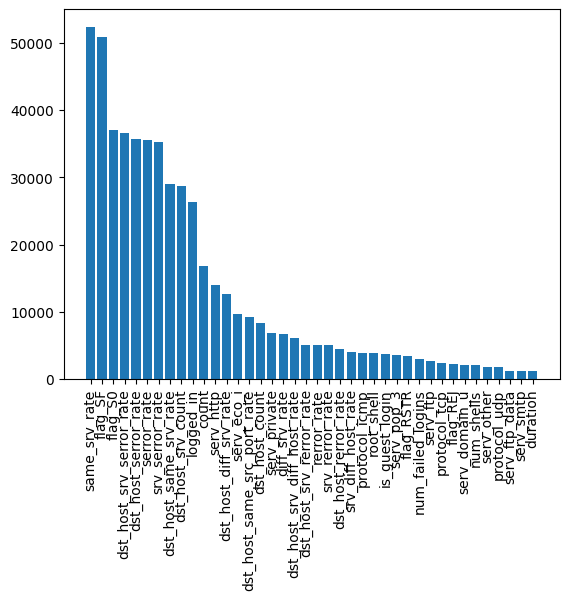

In [15]:
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=50)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]
#print("Selected Features:", selected_features)
feature_scores = list(zip(selector.scores_, X_train.columns))
sorted_feature_scores = sorted(feature_scores, reverse=True)
num_list = []
col_list = []
for i in range(40):
    num_list.append((sorted_feature_scores[i])[0])
    col_list.append((sorted_feature_scores[i])[1])


plt.bar(col_list, num_list)
plt.xticks(rotation=90)
plt.show()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [16]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
colonnes_pertinentes = mutual_info.sort_values(ascending=False).index

n_caracteristiques_pertinentes = 60 
X_train_pertinent = X_train[colonnes_pertinentes[:n_caracteristiques_pertinentes]]
X_test_pertinent = X_test[colonnes_pertinentes[:n_caracteristiques_pertinentes]]

In [17]:
X_train_pertinent.shape

(118324, 60)

In [20]:
knn = KNeighborsClassifier(5,p=1)
knn_model = knn.fit(X_train_selected, y_train)
Y_test = knn_model.predict(X_test_selected)

In [21]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_selected, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_selected, y_test)))

Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.99


In [22]:
knn = KNeighborsClassifier(5,p=1)
knn_model = knn.fit(X_train_pertinent, y_train)
Y_test = knn_model.predict(X_test_pertinent)

In [23]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_pertinent, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_pertinent, y_test)))

Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.99
